# Household or Handheld: A statistical report on the mean sales of handheld devices vs home consoles.

# Introduction

While some individuals enjoy the convenience and lower price tag of handheld games such as the DS, others may prefer the traditional experience that home gaming consoles like Wii provide.  As the video game industry continues to grow, gaming companies can gain insight by looking at the popularity of these two platforms to decide which direction to launch their next project.

Due to the high popularity of console gaming in North America, with over half of American households owning a gaming console *(1)*, we expect there will be a significant difference in the mean game sales, with the mean sales of console video games being higher than that of handheld games. With that being said, we are not confident enough in this claim to make our testing one-sided, therefore, in our project we will be exploring the research question, "Is there a difference in the popularity of handheld devices and home consoles for gaming in North America?".

To answer this inferential question, the dataset we will be investigating is the "Video Game Sales" dataset found on Kaggle, by Gregory Smith, with our location parameter being the mean and the scale parameter being the standard deviation. The dataset consists of the sales data for 10,129 games released in North America from 1980 to 2020. However, we chose to use 2001 as a cutoff year because it is the release year of modern milestones, the Xbox (home system), and the Game Boy Advance (handheld). *(2)* There are 11 variables, but we are only interested in North American sales in millions and the platform. There are no missing values in this dataset.


# Methods and Results

In [15]:
# uncomment and run if tidymodels does not exist
install.packages("tidymodels")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [16]:
# Loading the packages we need
library(tidyverse)
library(tidymodels)

options(repr.plot.width = 10, repr.plot.height = 8)
options(repr.matrix.max.rows = 6)

In [17]:
# Allows for the data to be reproducible
set.seed(100)

# Grabbing the data
url <- "https://raw.githubusercontent.com/xonew/Stat-201-21-Project/main/vgsales.csv"

#Reading data into R
gaming_dataset <- read_csv(url)

#Selecting columns we need for our analysis
gaming_data <- gaming_dataset %>%
filter(
Year > 2001,
NA_Sales > 0) %>%
select(Platform, NA_Sales) |>
  mutate(Platform = if_else(Platform %in% c("DS", "GBA", "GB", "PSV", "PSP"), "Handheld", "Home_Console"))

gaming_data

Rows: 16598 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Name, Platform, Year, Genre, Publisher
dbl (6): Rank, NA_Sales, EU_Sales, JP_Sales, Other_Sales, Global_Sales

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Platform,NA_Sales
<chr>,<dbl>
Home_Console,41.49
Home_Console,15.85
Home_Console,15.75
⋮,⋮
Handheld,0.01
Home_Console,0.01
Handheld,0.01


(Table 1: Table with tidy data)

We are interested in two columns:
- **Platform**: Platform on which video game is played (Home_Console or Handheld)
- **NA_Sales**: North American sales (in millions)


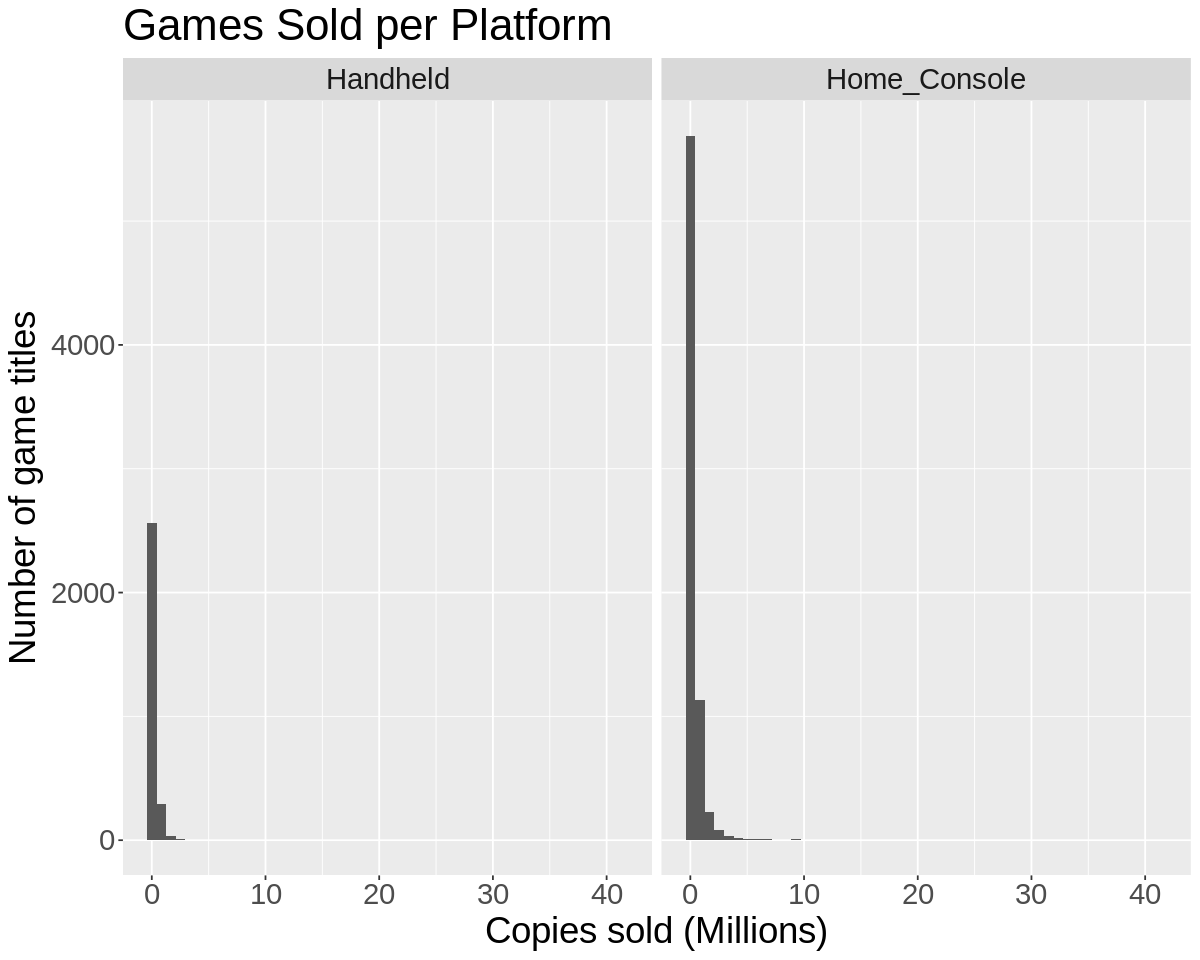

In [18]:
#Comparing the sampling distributions of handheld and home console systems in North America
gaming_data_dist_na <-
gaming_data %>%
  ggplot() +
  geom_histogram(aes(x = NA_Sales), bins = 50) +
  facet_wrap(~ Platform) +
  xlab("Copies sold (Millions)") +
  ylab("Number of game titles") +
  ggtitle("Games Sold per Platform")+
  theme(text = element_text(size = 22))
gaming_data_dist_na

(Figure 1.1: Sampling distribution for games for each platform)

As we can see from *Figure 1.1*, the sampling distributions for both platforms are heavily right-skewed unimodal distributions. The number of total sales for home console systems eclipses that of the sales for handheld console systems, but the centers of the distributions appear to be fairly close to one another. Note that there are values on the right of the graph, but they are not visible due to being too small.

In [19]:
# Grabbing total sales and titles
total_sales <- sum(gaming_data$NA_Sales)
total_titles <- NROW(gaming_data)

# Computing summary statistics
sum_stats <-
  gaming_data |>
  group_by(Platform) |>
  summarise(Num_Titles = n(),
            Sales_Total = sum(NA_Sales),
            Titles_Proportion = Num_Titles/total_titles,
            Sales_Proportion = Sales_Total/total_sales,
            Sales_Mean = mean(NA_Sales),
            Sales_SD = sd(NA_Sales))
Means_Diff  <- c(sum_stats$Sales_Mean[2]-sum_stats$Sales_Mean[1], "x")

# Degrees of freedom for our two sample t-test
Deg_Freedom <- c((sum_stats$Sales_SD[1]/sum_stats$Num_Titles[1] + sum_stats$Sales_SD[2]/sum_stats$Num_Titles[2])^2/(
                            sum_stats$Sales_SD[1]^4/(sum_stats$Num_Titles[1]^2*(sum_stats$Num_Titles[1])) +
                              sum_stats$Sales_SD[2]^4/(sum_stats$Num_Titles[2]^2*(sum_stats$Num_Titles[2]))), "x")

# Displaying the text
cbind(sum_stats, Means_Diff, Deg_Freedom)

Platform,Num_Titles,Sales_Total,Titles_Proportion,Sales_Proportion,Sales_Mean,Sales_SD,Means_Diff,Deg_Freedom
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Handheld,2912,667.83,0.2874914,0.2015963,0.2293372,0.5101972,0.137141921185023,19848.0371669035
Home_Console,7217,2644.88,0.7125086,0.7984037,0.3664791,0.9114268,x,x


(Table 1.2: Summary statistics for the two platforms)

The total number of titles and sales for each type of console are shown, as well as their proportion of titles and sales. We can see that the number of titles for handheld systems is under-represented by their sales, which points to a difference in means.

Sample estimates for our center and scale variables have also been calculated: the mean and standard deviation, respectively. We chose to use these types of parameters because they are sensitive to outliers, which corresponds well to our heavily skewed dataset.

Finally, we have an estimate of our parameter of interest: the difference in means. It is not zero, but whether it is "significantly not zero" needs to be investigated. We also have calculated the degrees of freedom that will be used in the upcoming t-test.

### Hypothesis Testing

This report seems to be trustworthy because the dataset is quite large, uses current data (2001-2015), and the data points are distinct. The plots and statistics we have provided thus far provide an estimate of our relevant parameters but they are not enough by itself to prove a significant difference in means.

In order to determine whether there is a significant difference in means, we will conduct a two-sided simulation-based hypothesis test using permutation. We will also conduct a two-sided two-sample t-test using t test with 19848 degrees of freedom. The Central Limit Theorem will apply as our large sample size; we need this due to our highly skewed sample.

The p-values of both hypothesis tests will be tested against a significance level of 0.05 as this is the most common significance level used in the sciences *(3)*.

Null hypothesis (H0): There is no significant difference in means between handheld and home console sales in North America.  

                                                    𝐻0: 𝜇1 − 𝜇2 = 𝑑0

Alternative hypothesis (H1): There is a significant difference in means between handheld and home console sales in North America.  

                                                    𝐻1: 𝜇1 − 𝜇2 ≠ 𝑑0


**Simulation Based Hypothesis Test Using Permutation**

In [20]:
#calculating the observed mean difference between Console game sales and handheld game sales
obs_mean_sales_diff <- gaming_data |>
specify(formula = NA_Sales ~ Platform) |>
calculate(stat="diff in means", order=c("Home_Console", "Handheld"))

obs_mean_sales_diff

stat
<dbl>
0.1371419


(Table 1.3: Mean difference in sales between the two consoles)

In [32]:
#Simulating the null distribution
null_diff_in_means <- gaming_data |>
specify(formula = NA_Sales ~ Platform) |>
hypothesize(null="independence") |>
generate(reps=1000, type = "permute") |>
calculate(stat="diff in means", order=c("Home_Console", "Handheld"))

head(null_diff_in_means)

replicate,stat
<int>,<dbl>
1,1.065897e-02
2,-5.858080e-03
3,1.782584e-02
4,8.711822e-03
5,-2.165027e-06
6,-1.830250e-02


(Tables 1.4: Null difference in means)

Here we have used the infer package to obtain the observed mean difference between console and handheld games (in that order).  We then simulated the null distribution using permutation with the infer package.  We did so using 1000 different permutations, We then simulated the null distribution using the infer package.  We did so using 1000 different permutations, where in each permutation the handheld games and console games are randomly assigned to different values from the NA_Sales column and the mean difference is calculated in each sample.

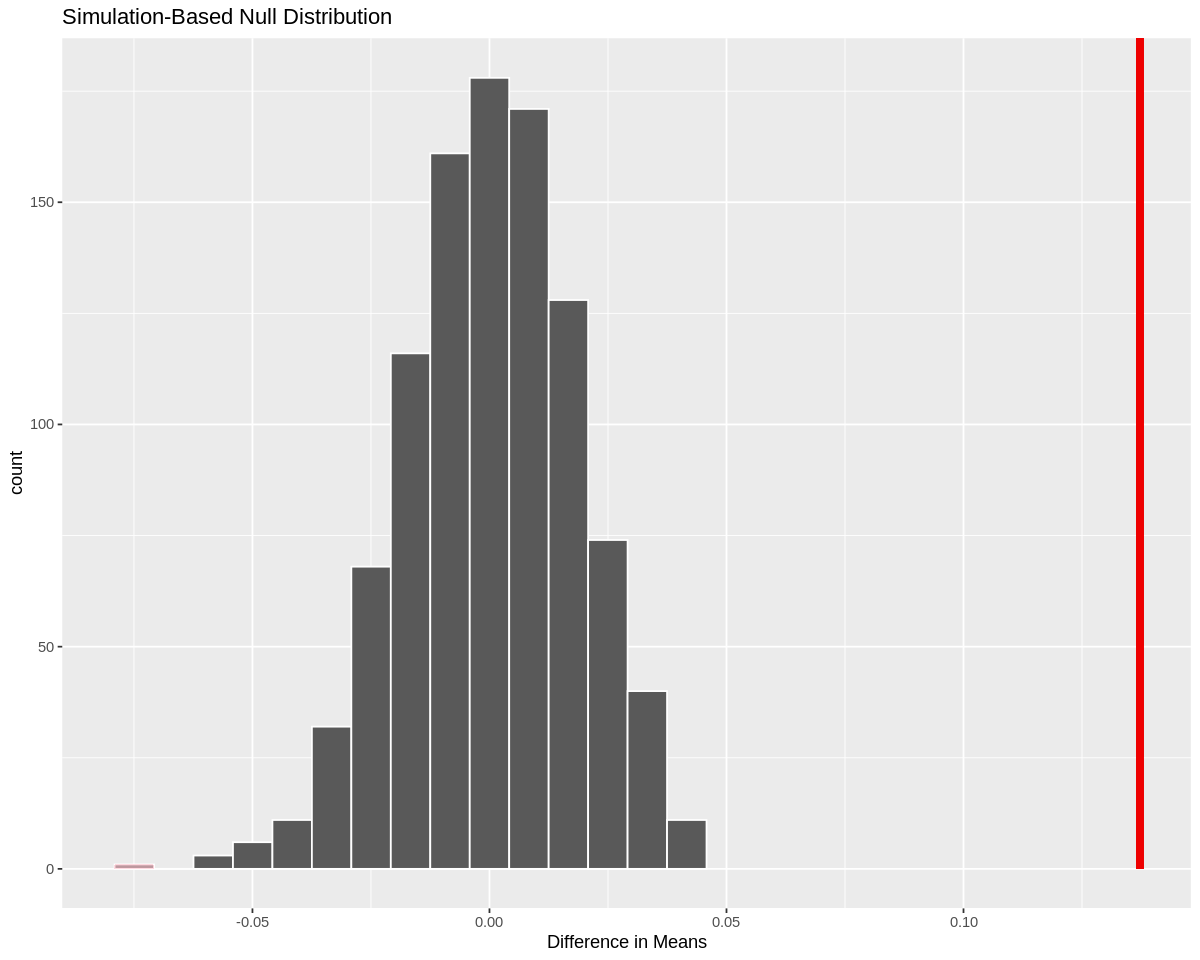

In [33]:
# Allowing the data to be reproducible
set.seed(100)

#Visualising the null distribution and where our obersved test statistic lies
diff_in_means_plot <- null_diff_in_means |>
visualize() +
shade_p_value(obs_stat= obs_mean_sales_diff, direction= "both") +
xlab("Difference in Means")

diff_in_means_plot

(Figure 1.2)

Here we visualise this simulated null distribution via a histogram and shade the values that are more extreme than the observed test statistic in red.

In [23]:
# Allowing the data to be reproducible
set.seed(100)

#obtaining p-value
p_value <- null_diff_in_means %>%
  get_p_value(obs_stat = obs_mean_sales_diff, direction = "both")

p_value

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


(Table 1.5)

Here we have obtained the p-value from our simulated hypothesis testing. It is much smaller than 0.01, therefore at our signficance level of 0.05 we will reject the null hypothesis that the mean sales of handheld games is equivalent to that of console games in North America. Our evidence supports the alternative hypothesis that handheld game sales are different than console game sales in North America. This simulation based hypothesis test is very handy as it relies on very few assumptions, however the next hypothesis test we will do is a little more strict.

**Hypothesis Testing using 2 Sample T-Test**

This test is dependent on the data being distributed normally, so it's important to ensure that the conditions of the central limit theorem are satisfied.The underlying data is skewed, but this is okay as the sample size is extremely large so the CLT will apply. Secondly, our data is a random sample of obervations.  Third, the observations in the sample are independent as, generally, none of the game sales affect the sales of the other video games. Knowing all of this, the central limit theorem should apply and thus it is safe to assume our data will be roughly normally distributed.

In [24]:
# Allowing the data to be reproducible
set.seed(100)

#Computing Summary Statistics (similar to sum stats but mure concise, also comupting variance instead of standard deviation)
console_handheld_summary <- gaming_data %>%
     select(Platform, NA_Sales) %>%
     group_by(Platform) %>%
     summarise(n = n(),
               mean = mean(NA_Sales),
               var = var(NA_Sales),
               `.groups` = "drop") %>%
     pivot_wider(names_from = Platform, values_from = c(n, mean, var))

#Calculating and adding a column that shows the observed mean difference
console_handheld_summary <- console_handheld_summary %>%
mutate(mean_diff=mean_Home_Console-mean_Handheld)

#Caclulating the standard error under the null and adding a column that shows it
console_handheld_summary <- console_handheld_summary %>%
mutate(null_std_error= sqrt(var_Home_Console/n_Home_Console+var_Handheld/n_Handheld))

#Calculating the test statistic and adding a column that shows it
console_handheld_summary <- console_handheld_summary %>%
mutate(test_statistic=mean_diff/null_std_error)

#Calculating the p-value and adding a column that shows it
console_handheld_summary <- console_handheld_summary %>%
mutate(p_value=2*(1-pt(test_statistic, df=19848.0371669035)))


console_handheld_summary

n_Handheld,n_Home_Console,mean_Handheld,mean_Home_Console,var_Handheld,var_Home_Console,mean_diff,null_std_error,test_statistic,p_value
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2912,7217,0.2293372,0.3664791,0.2603012,0.8306988,0.1371419,0.01430008,9.590292,0


(Table 1.6)

Here we start by summarizing the number of console and handheld games that are sold, the mean sales of console and handheld games, as well as the variance of sales of console and handheld games.  Next, we calculate the mean difference by subtracting the mean sales of a handheld game from that of a console game.  After this, we calculate the standard error under the null distribution which follows the formula $sqrt(s_1^2/n_1+s_2^2/n_2).$  We then calculate the test statistic by taking the mean difference and dividing it by the standard error.  Finally, we calculate the p-value by putting our test statistic and degrees of freedom (from earlier) in the pt function which shows the probability of getting a more extreme value than our test statistic (on either side) under the t-distribution.  The t-distribution is used here since we do not have the population standard deviation and thus have to estimate it based on our sample.  As in our simulation based hypothesis test the p-value is extremely small (smaller than 0.01) and thus at our signficance level of 0.05 we will reject the null hypothesis that the mean sales of handheld games is equivalent to that of console games in North America in favour of the alternative hypothesis that handheld game sales are different than console game sales in North America.

In [25]:
# Allowing the data to be reproducible
set.seed(100)

#Creating a dataset with only console games
console <- gaming_data |>
select(Platform, NA_Sales) |>
filter(Platform=="Home_Console")

#Creating a dataset with only handheld games
handheld <- gaming_data |>
select(Platform, NA_Sales) |>
filter(Platform=="Handheld")

#Doing a T-test on our data (Yields same results as before but used it here to ensure our numbers were correct)
console_handheld_t_test <- tidy(
        t.test(x = console$NA_Sales,
               y = handheld$NA_Sales,
               alternative = "two.sided"))

console_handheld_t_test

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.1371419,0.3664791,0.2293372,9.590292,1.111168e-21,9128.52,0.1091106,0.1651733,Welch Two Sample t-test,two.sided


(Table 1.7)

Here we have confirmed our results our 2 sample t-test using a more straight forward t.test function.  You can see the test statistic is the same, but one benefit is that we get a more precise, unrounded p-value of 1.111168e-21. Either way supports our results.

**95% Confidence Interval**

Now, we will obtain a 95% confidence interval using the central limit theorem to support our hypothesis test results. 95% is the chosen interval so that the interval is consistent with the hypothesis test's significance level of 0.05.

In [27]:
# Allowing the data to be reproducible
set.seed(100)

#Obtaining a 95% Confidence interval for the mean difference between Console game sales and Handheld games sales (in that order)
console_handheld_clt_ci <-
     tibble(lower_ci = console_handheld_summary$mean_diff - (qnorm(0.975)*console_handheld_summary$null_std_error),
            upper_ci = console_handheld_summary$mean_diff + (qnorm(0.975)*console_handheld_summary$null_std_error))

console_handheld_clt_ci

#Same thing except using t-distribution.  Gives very similar results due to our large sample size.
clt_t_ci <-
     tibble(lower_ci = console_handheld_summary$mean_diff - (qt(0.975, df=19848.0371669035)*console_handheld_summary$null_std_error),
            upper_ci = console_handheld_summary$mean_diff + (qt(0.975, df=19848.0371669035)*console_handheld_summary$null_std_error))

clt_t_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.1091143,0.1651696


lower_ci,upper_ci
<dbl>,<dbl>
0.1091126,0.1651713


(Tables 1.8 and 1.9)

Here we have

Comparison between permutation distribution and asymptotic approximation

# Discussion

**Results and Findings**

We have found that there is a statistically-significant difference between the mean sales of handheld games and the mean sales of home console games based on the results of our hypothesis test. Both the permutation and aymptotic approximation methods show that the likelihood of the means sales being the same is incredibly small, much smaller than our significance level of 5%.

**Impact**

**Future Questions**

Future questions this could exploration could lead to are:
- If this inferential question used a dataset with a shorter range of years, how would the results differ? Would this exploration be able to find specific years where handheld games were more popular than or were equally as popular than home consoles?

- If this inferential question used a dataset with with data from only the past few years, how would the results differ from this exploration (which contains data from 2001-2020)? Do console games remain more popular in 2020-2023, or has the trend changed?

- Is this difference due to popularity of specific consoles (Wii, PS) rather than whether it were a handheld or home console?
    - Other variations of this question could be investigating the effect of the company that manufactured the console or the genre of the game.  


# References

0. GregorySmith. (2016, October 26). Video game sales. Kaggle. https://www.kaggle.com/datasets/gregorut/videogamesales

1. Owens, T. (2022, August 11). Gaming console ownership and purchase intentions among households in the United States as of May 2021. Statista. https://www.statista.com/statistics/1277164/purchase-video-game-consoles/

2. Encyclopædia Britannica, inc. (2023, July 19). Xbox. Encyclopædia Britannica. https://www.britannica.com/technology/Xbox

3. Ross, Sheldon M. (2017). Chapter 9 - Testing Statistical Hypothesis. Introductory Statistics (Fourth edition). https://doi.org/10.1016/B978-0-12-804317-2.00009-6